In [ ]:
import sys
import argparse
import numpy as np
from matplotlib import pyplot as plt
import scipy
import PYCCF as myccf
from scipy import stats 
import pandas as pd
start_day = 0
end_day = 365

# CCF of simulated LC

In [5]:
lc1 = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/2433_light_curve.csv'
lc2 = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6800_light_curve.csv'

def pyccf_func(lc1, lc2, start_day, end_day,cadence, name):
    
    #!/usr/bin/python
    #-*- coding: utf-8 -*-
    """ The following is a demonstration of how to use the PYCCF.
    It requires the two light curves (also provided) sample_lc1.dat
    and sample_lc2.dat. It will output three data files containing the
    CCF, CCCD, and CCPD, and one plot showing the light curves, CCF,
    CCCD, and CCPD, all into the current directory. 
    """

    ########################################
    ###Read in two light curves
    ########################################
    """
    lc1 = "C:/Users/nikko/Desktop/Dissertation/Code/IMCCF/input/sample_lc1.dat"
    lc2 = "C:/Users/nikko/Desktop/Dissertation/Code/IMCCF/input/sample_lc2.dat"
    mjd1, flux1, err1 =  np.loadtxt(lc1, unpack = True, usecols = [0, 1, 2])
    mjd2, flux2, err2 =  np.loadtxt(lc2, unpack = True, usecols = [0, 1, 2])
    print(type(mjd1))

    """
    lc1_dat = pd.read_csv(lc1)[start_day:end_day:cadence]
    lc2_dat = pd.read_csv(lc2)[start_day:end_day:cadence]

    #lc1 = lc1[start_day:end_day]
    #lc2 = lc2[start_day:end_day]

    mjd1 = lc1_dat['time'].values
    flux1 =  (lc1_dat['normalised_flux [arbitary unit]'].values)
    err1 = (lc1_dat['error'].values)

    mjd2 = lc2_dat['time'].values
    flux2 =  (lc2_dat['normalised_flux [arbitary unit]'].values)
    err2 = (lc2_dat['error'].values)


    #########################################
    ##Set Interpolation settings, user-specified
    #########################################
    lag_range = [-250, 250]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
    interp = 1 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
    nsim = 5000  #Number of Monte Carlo iterations for calculation of uncertainties #10000 sim, less than 1%
    mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
    sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.

    ##########################################
    #Calculate lag with python CCF program
    ##########################################
    tlag_peak, status_peak, tlag_centroid, status_centroid, ccf_pack, max_rval, status_rval, pval = myccf.peakcent(mjd1, flux1, mjd2, flux2, lag_range[0], lag_range[1], interp)
    tlags_peak, tlags_centroid, nsuccess_peak, nfail_peak, nsuccess_centroid, nfail_centroid, max_rvals, nfail_rvals, pvals = myccf.xcor_mc(mjd1, flux1, abs(err1), mjd2, flux2, abs(err2), lag_range[0], lag_range[1], interp, nsim = nsim, mcmode=mcmode, sigmode = 0.2)

    lag = ccf_pack[1]
    r = ccf_pack[0]

    perclim = 84.1344746    

    ###Calculate the best peak and centroid and their uncertainties using the median of the
    ##distributions. 
    centau = stats.scoreatpercentile(tlags_centroid, 50)
    centau_uperr = (stats.scoreatpercentile(tlags_centroid, perclim))-centau
    centau_loerr = centau-(stats.scoreatpercentile(tlags_centroid, (100.-perclim)))
    print('Centroid, error: %10.3f  (+%10.3f -%10.3f)'%(centau, centau_loerr, centau_uperr))

    peaktau = stats.scoreatpercentile(tlags_peak, 50)
    peaktau_uperr = (stats.scoreatpercentile(tlags_peak, perclim))-centau
    peaktau_loerr = centau-(stats.scoreatpercentile(tlags_peak, (100.-perclim)))
    print('Peak, errors: %10.3f  (+%10.3f -%10.3f)'%(peaktau, peaktau_uperr, peaktau_loerr))


    ##########################################
    #Write results out to a file in case we want them later.
    ##########################################
    output_file_folder = ''
    centfile = open(output_file_folder+name+'_centtab_yap.dat', 'w')
    peakfile = open(output_file_folder+name+'_peaktab_yap.dat', 'w')
    ccf_file = open(output_file_folder+name+'_ccf_yap.dat', 'w')
    for m in range(0, np.size(tlags_centroid)):
        centfile.write('%5.5f    \n'%(tlags_centroid[m]))
    centfile.close()
    for m in range(0, np.size(tlags_peak)):
        peakfile.write('%5.5f    \n'%(tlags_peak[m]))
    peakfile.close()
    for m in range(0, np.size(lag)):
        ccf_file.write('%5.5f    %5.5f  \n'%(lag[m], r[m]))
    ccf_file.close() 


    ##########################################
    #Plot the Light curves, CCF, CCCD, and CCPD
    ##########################################

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace = 0.1)

    #Plot lightcurves
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.errorbar(mjd1, flux1, yerr = err1, marker = '.', linestyle = ':', color = 'k', label = 'LC 1 (Continuum)')
    ax1_2 = fig.add_subplot(3, 1, 2, sharex = ax1)
    ax1_2.errorbar(mjd2, flux2, yerr = err2, marker = '.', linestyle = ':', color = 'k', label = 'LC 2 (Emission Line)')

    ax1.text(0.025, 0.825, lc1, fontsize = 15, transform = ax1.transAxes)
    ax1_2.text(0.025, 0.825, lc2, fontsize = 15, transform = ax1_2.transAxes)
    ax1.set_ylabel('LC 1 Flux')
    ax1_2.set_ylabel('LC 2 Flux')
    ax1_2.set_xlabel('MJD')

    #Plot CCF Information
    xmin, xmax = -99, 99
    ax2 = fig.add_subplot(3, 3, 7)
    ax2.set_ylabel('CCF r')
    ax2.text(0.2, 0.85, 'CCF ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax2.transAxes, fontsize = 16)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)
    ax2.plot(lag, r, color = 'k')

    ax3 = fig.add_subplot(3, 3, 8, sharex = ax2)
    ax3.set_xlim(xmin, xmax)
    ax3.axes.get_yaxis().set_ticks([])
    ax3.set_xlabel('Centroid Lag: %5.1f (+%5.1f -%5.1f) days'%(centau, centau_uperr, centau_loerr), fontsize = 15) 
    ax3.text(0.2, 0.85, 'CCCD ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax3.transAxes, fontsize = 16)
    n, bins, etc = ax3.hist(tlags_centroid, bins = 50, color = 'b')

    ax4 = fig.add_subplot(3, 3, 9, sharex = ax2)
    ax4.set_ylabel('N')
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position('right') 
    #ax4.set_xlabel('Lag (days)')
    ax4.set_xlim(xmin, xmax)
    ax4.text(0.2, 0.85, 'CCPD ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax4.transAxes, fontsize = 16)
    ax4.hist(tlags_peak, bins = bins, color = 'b')

    plt.savefig(output_file_folder+name+'_plot.png', format = 'png', orientation = 'landscape', bbox_inches = 'tight') 
    plt.close(fig)
         


In [ ]:
lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/2433_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/3093_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/4387_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/5373_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6000_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6800_light_curve.csv'

pyccf_func(lc_u, lc_y, start_day, end_day,, name = 'uy')

TypeError: pyccf_func() missing 1 required positional argument: 'cadence'

In [16]:
pyccf_func(lc_u, lc_z, start_day, end_day, 'uz')

Failed centroids:  0
Failed peaks:  0
Centroid, error:     33.637  (+     2.006 -     1.866)
Peak, errors:     16.500  (+   -16.137 -    17.137)


In [17]:
pyccf_func(lc_u, lc_i, start_day, end_day, 'ui')

Failed centroids:  0
Failed peaks:  0
Centroid, error:     29.040  (+     2.215 -     2.100)
Peak, errors:     13.500  (+   -14.540 -    15.540)


In [19]:
pyccf_func(lc_u, lc_r, start_day, end_day, 'ur')

Failed centroids:  0
Failed peaks:  0
Centroid, error:     20.914  (+     2.629 -     2.480)
Peak, errors:      8.500  (+   -11.414 -    12.414)


In [20]:
pyccf_func(lc_u, lc_g, start_day, end_day, 'ug')

Failed centroids:  0
Failed peaks:  0
Centroid, error:      7.250  (+     3.191 -     3.104)
Peak, errors:      2.500  (+    -4.750 -     4.750)


# Realistic Dates

In [ ]:
lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/2433_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/3093_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/4387_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/5373_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6000_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6800_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'uy_mjd')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'uz_mjd')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'ui_mjd')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'ur_mjd')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'ug_mjd')

Failed centroids:  0
Failed peaks:  0
Centroid, error:     39.107  (+     2.776 -     2.527)
Peak, errors:     21.000  (+   -18.107 -    18.107)
Failed centroids:  0
Failed peaks:  0
Centroid, error:     33.543  (+     2.859 -     2.780)
Peak, errors:     17.000  (+   -16.543 -    16.543)
Failed centroids:  0
Failed peaks:  0
Centroid, error:     28.988  (+     3.143 -     2.944)
Peak, errors:     13.000  (+   -13.988 -    15.988)
Failed centroids:  0
Failed peaks:  0
Centroid, error:     20.719  (+     3.808 -     3.557)
Peak, errors:      9.000  (+   -11.719 -    11.719)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      7.196  (+     4.552 -     4.439)
Peak, errors:      3.000  (+    -4.196 -     4.196)


Failed centroids:  0
Failed peaks:  0
Centroid, error:     29.922  (+     1.925 -     2.376)
Peak, errors:     21.000  (+    -8.922 -    10.922)
Failed centroids:  0
Failed peaks:  0
Centroid, error:     24.513  (+     1.841 -     1.974)
Peak, errors:     17.000  (+    -7.513 -     7.513)
Failed centroids:  0
Failed peaks:  0
Centroid, error:     20.124  (+     1.524 -     1.868)
Peak, errors:     14.000  (+    -5.124 -     7.124)


KeyboardInterrupt: 

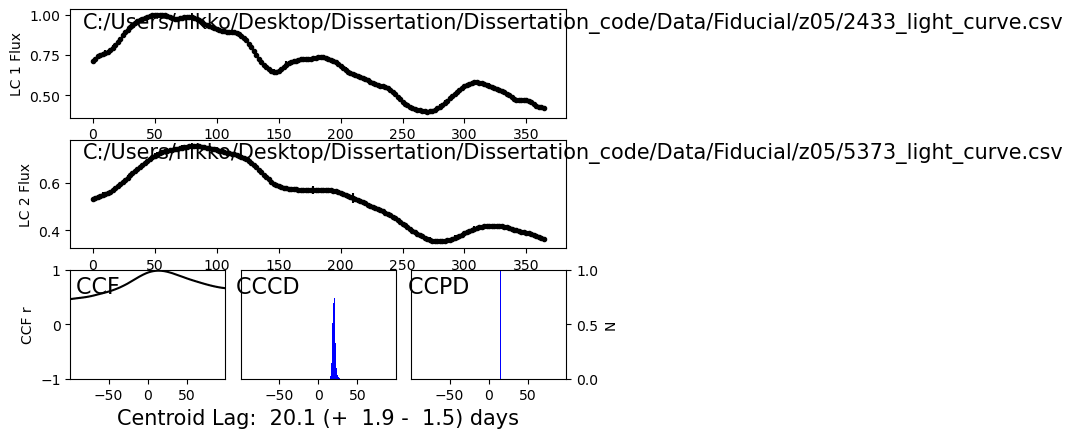

In [25]:
lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/2433_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/3093_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/4387_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/5373_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6000_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6800_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'uy_mjd_1y')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'uz_mjd_1y')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'ui_mjd_1y')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'ur_mjd_1y')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'ug_mjd_1y')

# normalised

In [12]:
def pyccf_func(lc1, lc2, start_day, end_day,cadence, name):
    
    #!/usr/bin/python
    #-*- coding: utf-8 -*-
    """ The following is a demonstration of how to use the PYCCF.
    It requires the two light curves (also provided) sample_lc1.dat
    and sample_lc2.dat. It will output three data files containing the
    CCF, CCCD, and CCPD, and one plot showing the light curves, CCF,
    CCCD, and CCPD, all into the current directory. 
    """

    ########################################
    ###Read in two light curves
    ########################################
    """
    lc1 = "C:/Users/nikko/Desktop/Dissertation/Code/IMCCF/input/sample_lc1.dat"
    lc2 = "C:/Users/nikko/Desktop/Dissertation/Code/IMCCF/input/sample_lc2.dat"
    mjd1, flux1, err1 =  np.loadtxt(lc1, unpack = True, usecols = [0, 1, 2])
    mjd2, flux2, err2 =  np.loadtxt(lc2, unpack = True, usecols = [0, 1, 2])
    print(type(mjd1))

    """
    lc1_dat = pd.read_csv(lc1)[start_day:end_day:cadence]
    lc2_dat = pd.read_csv(lc2)[start_day:end_day:cadence]

    #lc1 = lc1[start_day:end_day]
    #lc2 = lc2[start_day:end_day]

    mjd1 = lc1_dat['time [days]'].values
    flux1 =  (lc1_dat['normalised_flux [arbitary unit]'].values)
    err1 = (lc1_dat['error [arbitary unit]'].values)

    mjd2 = lc2_dat['time [days]'].values
    flux2 =  (lc2_dat['normalised_flux [arbitary unit]'].values)
    err2 = (lc2_dat['error [arbitary unit]'].values)


    #########################################
    ##Set Interpolation settings, user-specified
    #########################################
    lag_range = [-100, 100]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
    interp = 0.5 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
    nsim = 5000  #Number of Monte Carlo iterations for calculation of uncertainties #10000 sim, less than 1%
    mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
    sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.

    ##########################################
    #Calculate lag with python CCF program
    ##########################################
    tlag_peak, status_peak, tlag_centroid, status_centroid, ccf_pack, max_rval, status_rval, pval = myccf.peakcent(mjd1, flux1, mjd2, flux2, lag_range[0], lag_range[1], interp)
    tlags_peak, tlags_centroid, nsuccess_peak, nfail_peak, nsuccess_centroid, nfail_centroid, max_rvals, nfail_rvals, pvals = myccf.xcor_mc(mjd1, flux1, abs(err1), mjd2, flux2, abs(err2), lag_range[0], lag_range[1], interp, nsim = nsim, mcmode=mcmode, sigmode = 0.2)

    lag = ccf_pack[1]
    r = ccf_pack[0]

    perclim = 84.1344746    

    ###Calculate the best peak and centroid and their uncertainties using the median of the
    ##distributions. 
    centau = stats.scoreatpercentile(tlags_centroid, 50)
    centau_uperr = (stats.scoreatpercentile(tlags_centroid, perclim))-centau
    centau_loerr = centau-(stats.scoreatpercentile(tlags_centroid, (100.-perclim)))
    print('Centroid, error: %10.3f  (+%10.3f -%10.3f)'%(centau, centau_loerr, centau_uperr))

    peaktau = stats.scoreatpercentile(tlags_peak, 50)
    peaktau_uperr = (stats.scoreatpercentile(tlags_peak, perclim))-centau
    peaktau_loerr = centau-(stats.scoreatpercentile(tlags_peak, (100.-perclim)))
    print('Peak, errors: %10.3f  (+%10.3f -%10.3f)'%(peaktau, peaktau_uperr, peaktau_loerr))


    ##########################################
    #Write results out to a file in case we want them later.
    ##########################################
    output_file_folder = ''
    centfile = open(output_file_folder+name+'_centtab_yap.dat', 'w')
    peakfile = open(output_file_folder+name+'_peaktab_yap.dat', 'w')
    ccf_file = open(output_file_folder+name+'_ccf_yap.dat', 'w')
    for m in range(0, np.size(tlags_centroid)):
        centfile.write('%5.5f    \n'%(tlags_centroid[m]))
    centfile.close()
    for m in range(0, np.size(tlags_peak)):
        peakfile.write('%5.5f    \n'%(tlags_peak[m]))
    peakfile.close()
    for m in range(0, np.size(lag)):
        ccf_file.write('%5.5f    %5.5f  \n'%(lag[m], r[m]))
    ccf_file.close() 


    ##########################################
    #Plot the Light curves, CCF, CCCD, and CCPD
    ##########################################

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace = 0.1)

    #Plot lightcurves
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.errorbar(mjd1, flux1, yerr = err1, marker = '.', linestyle = ':', color = 'k', label = 'LC 1 (Continuum)')
    ax1_2 = fig.add_subplot(3, 1, 2, sharex = ax1)
    ax1_2.errorbar(mjd2, flux2, yerr = err2, marker = '.', linestyle = ':', color = 'k', label = 'LC 2 (Emission Line)')

    ax1.text(0.025, 0.825, lc1, fontsize = 15, transform = ax1.transAxes)
    ax1_2.text(0.025, 0.825, lc2, fontsize = 15, transform = ax1_2.transAxes)
    ax1.set_ylabel('LC 1 Flux')
    ax1_2.set_ylabel('LC 2 Flux')
    ax1_2.set_xlabel('MJD')

    #Plot CCF Information
    xmin, xmax = -99, 99
    ax2 = fig.add_subplot(3, 3, 7)
    ax2.set_ylabel('CCF r')
    ax2.text(0.2, 0.85, 'CCF ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax2.transAxes, fontsize = 16)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)
    ax2.plot(lag, r, color = 'k')

    ax3 = fig.add_subplot(3, 3, 8, sharex = ax2)
    ax3.set_xlim(xmin, xmax)
    ax3.axes.get_yaxis().set_ticks([])
    ax3.set_xlabel('Centroid Lag: %5.1f (+%5.1f -%5.1f) days'%(centau, centau_uperr, centau_loerr), fontsize = 15) 
    ax3.text(0.2, 0.85, 'CCCD ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax3.transAxes, fontsize = 16)
    n, bins, etc = ax3.hist(tlags_centroid, bins = 50, color = 'b')

    ax4 = fig.add_subplot(3, 3, 9, sharex = ax2)
    ax4.set_ylabel('N')
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position('right') 
    #ax4.set_xlabel('Lag (days)')
    ax4.set_xlim(xmin, xmax)
    ax4.text(0.2, 0.85, 'CCPD ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax4.transAxes, fontsize = 16)
    ax4.hist(tlags_peak, bins = bins, color = 'b')

    plt.savefig(output_file_folder+name+'_plot.png', format = 'png', orientation = 'landscape', bbox_inches = 'tight') 
    plt.close(fig)
         


lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/2433_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/3093_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/4387_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/5373_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6000_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6800_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'z05_uy_mjd_1y')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'z05_uz_mjd_1y')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'z05_ui_mjd_1y')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'z05_ur_mjd_1y')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'z05_ug_mjd_1y')

Failed centroids:  0
Failed peaks:  0
Centroid, error:      5.011  (+     0.492 -     0.497)
Peak, errors:      5.000  (+    -0.011 -     0.511)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      4.003  (+     0.493 -     0.491)
Peak, errors:      3.500  (+    -0.503 -     0.503)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      3.244  (+     0.495 -     0.492)
Peak, errors:      3.000  (+    -0.244 -     0.244)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      2.020  (+     0.497 -     0.669)
Peak, errors:      1.500  (+    -0.020 -     0.520)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      0.712  (+     0.678 -     0.523)
Peak, errors:      0.500  (+     0.288 -     0.212)


In [13]:
lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/1825_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/2320_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/3290_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/4030_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/4500_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/5100_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'z1_uy_mjd_1y')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'z1_uz_mjd_1y')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'z1_ui_mjd_1y')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'z1_ur_mjd_1y')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'z1_ug_mjd_1y')

Failed centroids:  0
Failed peaks:  0
Centroid, error:      4.730  (+     0.669 -     0.494)
Peak, errors:      4.500  (+    -0.230 -     0.730)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      3.740  (+     0.671 -     0.497)
Peak, errors:      3.000  (+    -0.240 -     0.740)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      2.997  (+     0.684 -     0.517)
Peak, errors:      3.000  (+     0.003 -     0.497)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      1.970  (+     0.684 -     0.507)
Peak, errors:      1.500  (+    -0.470 -     0.470)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      0.699  (+     0.893 -     0.744)
Peak, errors:      1.000  (+     0.301 -     0.199)


In [15]:
lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/1216_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/1546_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/2193_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/2686_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/3000_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/3400_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'z2_uy_mjd_1y')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'z2_uz_mjd_1y')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'z2_ui_mjd_1y')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'z2_ur_mjd_1y')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'z2_ug_mjd_1y')

Failed centroids:  0
Failed peaks:  0
Centroid, error:      4.089  (+     1.052 -     1.128)
Peak, errors:      3.000  (+     0.911 -     1.089)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      3.251  (+     0.987 -     0.987)
Peak, errors:      3.000  (+    -0.251 -     0.251)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      2.563  (+     1.007 -     1.132)
Peak, errors:      3.000  (+     0.437 -     1.063)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      1.709  (+     1.086 -     1.002)
Peak, errors:      1.000  (+    -0.209 -     0.709)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      0.502  (+     1.016 -     1.000)
Peak, errors:      1.000  (+     0.498 -     0.002)


# Scaled LC

In [17]:
def pyccf_func(lc1, lc2, start_day, end_day,cadence, name):
    
    #!/usr/bin/python
    #-*- coding: utf-8 -*-
    """ The following is a demonstration of how to use the PYCCF.
    It requires the two light curves (also provided) sample_lc1.dat
    and sample_lc2.dat. It will output three data files containing the
    CCF, CCCD, and CCPD, and one plot showing the light curves, CCF,
    CCCD, and CCPD, all into the current directory. 
    """

    ########################################
    ###Read in two light curves
    ########################################
    """
    lc1 = "C:/Users/nikko/Desktop/Dissertation/Code/IMCCF/input/sample_lc1.dat"
    lc2 = "C:/Users/nikko/Desktop/Dissertation/Code/IMCCF/input/sample_lc2.dat"
    mjd1, flux1, err1 =  np.loadtxt(lc1, unpack = True, usecols = [0, 1, 2])
    mjd2, flux2, err2 =  np.loadtxt(lc2, unpack = True, usecols = [0, 1, 2])
    print(type(mjd1))

    """
    lc1_dat = pd.read_csv(lc1)[start_day:end_day:cadence]
    lc2_dat = pd.read_csv(lc2)[start_day:end_day:cadence]

    #lc1 = lc1[start_day:end_day]
    #lc2 = lc2[start_day:end_day]

    mjd1 = lc1_dat['time [days]'].values
    flux1 =  (lc1_dat['noisy_flux [fnu]'].values)
    err1 = (lc1_dat['error [fnu]'].values)

    mjd2 = lc2_dat['time [days]'].values
    flux2 =  (lc2_dat['noisy_flux [fnu]'].values)
    err2 = (lc2_dat['error [fnu]'].values)


    #########################################
    ##Set Interpolation settings, user-specified
    #########################################
    lag_range = [-250, 250]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
    interp = 0.5 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
    nsim = 10000  #Number of Monte Carlo iterations for calculation of uncertainties #10000 sim, less than 1%
    mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
    sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.

    ##########################################
    #Calculate lag with python CCF program
    ##########################################
    tlag_peak, status_peak, tlag_centroid, status_centroid, ccf_pack, max_rval, status_rval, pval = myccf.peakcent(mjd1, flux1, mjd2, flux2, lag_range[0], lag_range[1], interp)
    tlags_peak, tlags_centroid, nsuccess_peak, nfail_peak, nsuccess_centroid, nfail_centroid, max_rvals, nfail_rvals, pvals = myccf.xcor_mc(mjd1, flux1, abs(err1), mjd2, flux2, abs(err2), lag_range[0], lag_range[1], interp, nsim = nsim, mcmode=mcmode, sigmode = 0.2)

    lag = ccf_pack[1]
    r = ccf_pack[0]

    perclim = 84.1344746    

    ###Calculate the best peak and centroid and their uncertainties using the median of the
    ##distributions. 
    centau = stats.scoreatpercentile(tlags_centroid, 50)
    centau_uperr = (stats.scoreatpercentile(tlags_centroid, perclim))-centau
    centau_loerr = centau-(stats.scoreatpercentile(tlags_centroid, (100.-perclim)))
    print('Centroid, error: %10.3f  (+%10.3f -%10.3f)'%(centau, centau_loerr, centau_uperr))

    peaktau = stats.scoreatpercentile(tlags_peak, 50)
    peaktau_uperr = (stats.scoreatpercentile(tlags_peak, perclim))-centau
    peaktau_loerr = centau-(stats.scoreatpercentile(tlags_peak, (100.-perclim)))
    print('Peak, errors: %10.3f  (+%10.3f -%10.3f)'%(peaktau, peaktau_uperr, peaktau_loerr))


    ##########################################
    #Write results out to a file in case we want them later.
    ##########################################
    output_file_folder = ''
    centfile = open(output_file_folder+name+'_centtab_yap.dat', 'w')
    peakfile = open(output_file_folder+name+'_peaktab_yap.dat', 'w')
    ccf_file = open(output_file_folder+name+'_ccf_yap.dat', 'w')
    for m in range(0, np.size(tlags_centroid)):
        centfile.write('%5.5f    \n'%(tlags_centroid[m]))
    centfile.close()
    for m in range(0, np.size(tlags_peak)):
        peakfile.write('%5.5f    \n'%(tlags_peak[m]))
    peakfile.close()
    for m in range(0, np.size(lag)):
        ccf_file.write('%5.5f    %5.5f  \n'%(lag[m], r[m]))
    ccf_file.close() 


    ##########################################
    #Plot the Light curves, CCF, CCCD, and CCPD
    ##########################################

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace = 0.1)

    #Plot lightcurves
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.errorbar(mjd1, flux1, yerr = err1, marker = '.', linestyle = ':', color = 'k', label = 'LC 1 (Continuum)')
    ax1_2 = fig.add_subplot(3, 1, 2, sharex = ax1)
    ax1_2.errorbar(mjd2, flux2, yerr = err2, marker = '.', linestyle = ':', color = 'k', label = 'LC 2 (Emission Line)')

    ax1.text(0.025, 0.825, lc1, fontsize = 15, transform = ax1.transAxes)
    ax1_2.text(0.025, 0.825, lc2, fontsize = 15, transform = ax1_2.transAxes)
    ax1.set_ylabel('LC 1 Flux')
    ax1_2.set_ylabel('LC 2 Flux')
    ax1_2.set_xlabel('MJD')

    #Plot CCF Information
    xmin, xmax = -99, 99
    ax2 = fig.add_subplot(3, 3, 7)
    ax2.set_ylabel('CCF r')
    ax2.text(0.2, 0.85, 'CCF ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax2.transAxes, fontsize = 16)
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(-1.0, 1.0)
    ax2.plot(lag, r, color = 'k')

    ax3 = fig.add_subplot(3, 3, 8, sharex = ax2)
    ax3.set_xlim(xmin, xmax)
    ax3.axes.get_yaxis().set_ticks([])
    ax3.set_xlabel('Centroid Lag: %5.1f (+%5.1f -%5.1f) days'%(centau, centau_uperr, centau_loerr), fontsize = 15) 
    ax3.text(0.2, 0.85, 'CCCD ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax3.transAxes, fontsize = 16)
    n, bins, etc = ax3.hist(tlags_centroid, bins = 50, color = 'b')

    ax4 = fig.add_subplot(3, 3, 9, sharex = ax2)
    ax4.set_ylabel('N')
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position('right') 
    #ax4.set_xlabel('Lag (days)')
    ax4.set_xlim(xmin, xmax)
    ax4.text(0.2, 0.85, 'CCPD ', horizontalalignment = 'center', verticalalignment = 'center', transform = ax4.transAxes, fontsize = 16)
    ax4.hist(tlags_peak, bins = bins, color = 'b')

    plt.savefig(output_file_folder+name+'_plot.png', format = 'png', orientation = 'landscape', bbox_inches = 'tight') 
    plt.close(fig)
         


lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/2433_scaled_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/3093_scaled_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/4387_scaled_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/5373_scaled_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6000_scaled_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z05/6800_scaled_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'z05_uy_mjd_1y_scaled')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'z05_uz_mjd_1y_scaled')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'z05_ui_mjd_1y_scaled')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'z05_ur_mjd_1y_scaled')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'z05_ug_mjd_1y_scaled')

Failed centroids:  0
Failed peaks:  0
Centroid, error:      4.953  (+     1.582 -     1.546)
Peak, errors:      5.000  (+     2.047 -     1.953)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      3.988  (+     1.418 -     1.319)
Peak, errors:      3.000  (+     1.012 -     2.988)
Failed centroids:  214
Failed peaks:  214
Centroid, error:      3.015  (+     3.105 -     3.070)
Peak, errors:      3.000  (+     3.985 -     4.015)
Failed centroids:  106
Failed peaks:  106
Centroid, error:      1.973  (+     2.971 -     2.953)
Peak, errors:      1.000  (+     3.027 -     2.973)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      0.557  (+     1.025 -     1.154)
Peak, errors:      1.000  (+     0.443 -     1.557)


In [18]:
lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/1825_scaled_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/2320_scaled_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/3290_scaled_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/4030_scaled_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/4500_scaled_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z1/5100_scaled_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'z1_uy_mjd_1y_scaled')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'z1_uz_mjd_1y_scaled')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'z1_ui_mjd_1y_scaled')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'z1_ur_mjd_1y_scaled')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'z1_ug_mjd_1y_scaled')

Failed centroids:  3639
Failed peaks:  3639
Centroid, error:      4.537  (+     2.197 -     2.360)
Peak, errors:      4.500  (+     2.463 -     3.537)
Failed centroids:  2852
Failed peaks:  2852
Centroid, error:      3.706  (+     1.976 -     1.964)
Peak, errors:      3.000  (+     1.294 -     2.706)
Failed centroids:  4369
Failed peaks:  4369
Centroid, error:      2.076  (+   224.583 -     3.907)
Peak, errors:      1.000  (+     4.924 -   225.076)
Failed centroids:  4346
Failed peaks:  4346
Centroid, error:      1.215  (+   225.425 -     4.305)
Peak, errors:      1.000  (+     5.785 -   226.215)
Failed centroids:  2170
Failed peaks:  2170
Centroid, error:      0.610  (+     1.832 -     1.781)
Peak, errors:      1.000  (+     0.390 -     1.610)


In [19]:
lc_u = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/1216_scaled_light_curve.csv'
lc_g = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/1546_scaled_light_curve.csv'
lc_r = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/2193_scaled_light_curve.csv'
lc_i = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/2686_scaled_light_curve.csv'
lc_z = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/3000_scaled_light_curve.csv'
lc_y = 'C:/Users/nikko/Desktop/Dissertation/Dissertation_code/Data/Fiducial/z2/3400_scaled_light_curve.csv'
pyccf_func(lc_u, lc_y, start_day, end_day,2, 'z2_uy_mjd_1y_scaled')
pyccf_func(lc_u, lc_z, start_day, end_day,2, 'z2_uz_mjd_1y_scaled')
pyccf_func(lc_u, lc_i, start_day, end_day,2, 'z2_ui_mjd_1y_scaled')
pyccf_func(lc_u, lc_r, start_day, end_day,2, 'z2_ur_mjd_1y_scaled')
pyccf_func(lc_u, lc_g, start_day, end_day,2, 'z2_ug_mjd_1y_scaled')

Failed centroids:  0
Failed peaks:  0
Centroid, error:      4.199  (+     2.046 -     2.000)
Peak, errors:      3.000  (+     0.801 -     1.199)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      2.910  (+     4.359 -     4.279)
Peak, errors:      3.000  (+     4.090 -     4.410)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      1.793  (+     5.781 -     6.024)
Peak, errors:      1.500  (+     7.207 -     6.793)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      1.740  (+     2.579 -     2.342)
Peak, errors:      1.000  (+     1.260 -     2.740)
Failed centroids:  0
Failed peaks:  0
Centroid, error:      0.641  (+     2.369 -     2.261)
Peak, errors:      1.000  (+     2.359 -     1.641)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


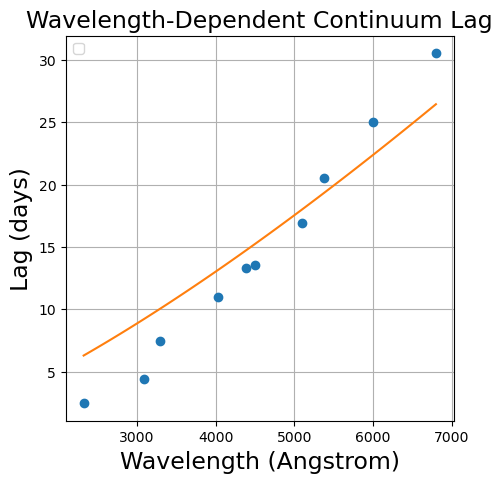

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the function to fit
def wavelength_func(wavelength, alpha):
    return alpha * wavelength**(4/3)

# Data points
lag = [2.482, 7.431, 11.026, 13.527, 16.917, 4.402, 13.281, 20.558, 24.985, 30.521]
wavelength = [2320, 3290, 4030, 4500, 5100, 3093, 4387, 5373, 6000, 6800]

# Fit the curve
popt, pcov = curve_fit(wavelength_func, wavelength, lag)
alpha = popt[0]
#alpha = lag[3]/wavelength[3]**(4/3)
# Generate fitted data
wavelength_fit = np.linspace(min(wavelength), max(wavelength), 100)
lag_fit = wavelength_func(wavelength_fit, alpha)

fig, ax = plt.subplots(1,1, figsize=(5,5))
# Plot the data points and the fitted line
plt.plot(wavelength, lag, 'o')#, label='Data points')
plt.plot(wavelength_fit, lag_fit, '-')#, label=f'Fit: $\\alpha \\cdot \\lambda^{{3/4}}$\n$\\alpha$ = {alpha:.3f}')
plt.xlabel('Wavelength (Angstrom)', fontsize=17)
plt.ylabel('Lag (days)', fontsize=17)
plt.title('Wavelength-Dependent Continuum Lag', fontsize=17)
plt.grid()
plt.legend()
plt.show()